## Assignment 2 For Clustering: Sessa Empirical Estimator
---
1. Read the Journals about the Sessa Empirical Estimator.
2. Convert the R codes into Python Codes (use jupyter notebook).
3. Using Simulated data (https://www.frontiersin.org/journals/pharmacology/articles/10.3389/fphar.2019.00383/full) or a real world datasets of your choice (You can obtain it in Kaggle or in https://archive.ics.uci.edu/), perform the Sessa Empircal Estimator and generate some insights.
4. The Sessa Empirical Estimator uses K-Means clustering (again recall the disadvantages of K-Means), try to substitute a different clustering algorithm, generate a new insight using the new clustering algorithm.
5. Compare your results between Sessa Empirical Estimator using K-Means, and Sessa Empirical Estimator using the clustering algorithm of your choice.
6. Create a callable function in each step. Check if these callable function has the same result (and insights) with your Jupyter Notebook.

## 1. Import Required Libraries
---

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from scipy.stats import gaussian_kde
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

## 2. Load and Prepare Data
---

In [6]:
def prepare_data(df):
    df = df.rename(columns={
        "PATIENT_ID": "pnr",
        "DATE": "eksd",
        "PERDAY": "perday",
        "CATEGORY": "ATC",
        "DURATION": "dur_original"
    })
    df["eksd"] = pd.to_datetime(df["eksd"], format="%m/%d/%Y")  # Assuming 'mm/dd/yyyy' format
    return df

df = pd.read_csv("csv/med_events.csv")
df = prepare_data(df)

## 3. Define See Function
---

In [7]:
def See(df, med_code):
    # Filter medication
    C09CA01 = df[df["ATC"] == med_code].copy()
    
    # Sort and compute event intervals
    C09CA01 = C09CA01.sort_values(by=["pnr", "eksd"])
    C09CA01["prev_eksd"] = C09CA01.groupby("pnr")["eksd"].shift(1)
    C09CA01["event_interval"] = (C09CA01["eksd"] - C09CA01["prev_eksd"]).dt.days
    C09CA01 = C09CA01.dropna().reset_index(drop=True)

    # Sample one record per patient
    np.random.seed(123)
    Drug_see_p1 = C09CA01.groupby("pnr").sample(n=1, random_state=123).reset_index(drop=True)

    # ECDF analysis (filtering values below the 80th percentile)
    quantile_80 = Drug_see_p1["event_interval"].quantile(0.8)
    dfper = Drug_see_p1[Drug_see_p1["event_interval"] <= quantile_80].copy()

    # Log-transform and scale data for clustering
    dfper.loc[:, "log_interval"] = np.log(dfper["event_interval"])
    scaler = StandardScaler()
    dfper.loc[:, "scaled"] = scaler.fit_transform(dfper[["log_interval"]])

    # Determine optimal clusters using silhouette method
    def find_optimal_k(data):
        best_k, best_score = 2, -1
        for k in range(2, 10):  # Testing k from 2 to 10
            kmeans = KMeans(n_clusters=k, random_state=1234, n_init=10).fit(data)
            score = silhouette_score(data, kmeans.labels_)
            if score > best_score:
                best_k, best_score = k, score
        return best_k
    
    max_cluster = find_optimal_k(dfper[["scaled"]])

    # Apply K-Means Clustering
    np.random.seed(1234)
    kmeans = KMeans(n_clusters=max_cluster, random_state=1234, n_init=10)
    dfper.loc[:, "cluster"] = kmeans.fit_predict(dfper[["scaled"]])

    # Create cluster ranges
    cluster_ranges = dfper.groupby("cluster")["event_interval"].agg(
        Minimum=lambda x: np.exp(min(np.log(x))),
        Maximum=lambda x: np.exp(max(np.log(x))),
        Median=lambda x: np.exp(np.median(np.log(x)))
    ).reset_index().sort_values(by="Median")

    # Merge cluster information
    dfper = dfper.merge(cluster_ranges, on="cluster", how="left")

    # Handling NA values
    main_cluster = dfper["cluster"].value_counts().idxmax()
    main_median = cluster_ranges.loc[cluster_ranges["cluster"] == main_cluster, "Median"].values[0]

    # Final data merge
    Drug_see_p0 = C09CA01.merge(
        dfper[["pnr", "Median", "cluster"]],
        on="pnr",
        how="left"
    )

    Drug_see_p0.loc[:, "Median"] = Drug_see_p0["Median"].fillna(main_median)
    Drug_see_p0.loc[:, "cluster"] = Drug_see_p0["cluster"].fillna(main_cluster)

    return Drug_see_p0

## 4.  Define see_assumption Function
---

In [8]:
def see_assumption(med_data):
    med_data = med_data.sort_values(by=["pnr", "eksd"])
    med_data["prev_eksd"] = med_data.groupby("pnr")["eksd"].shift(1)
    med_data["p_number"] = med_data.groupby("pnr").cumcount() + 1
    med_data["Duration"] = (med_data["eksd"] - med_data["prev_eksd"]).dt.days

    med_data = med_data[med_data["p_number"] >= 2].copy()  # Ensure we copy the filtered data
    
    overall_median = med_data["Duration"].median()

    plt.figure(figsize=(8, 6))
    sns.boxplot(x=med_data["p_number"].astype(str), y=med_data["Duration"])
    plt.axhline(y=overall_median, linestyle="dashed", color="red")
    plt.xlabel("Prescription Sequence Number")
    plt.ylabel("Duration (days)")
    plt.title("Prescription Interval Analysis")
    plt.show()

## 5. Define SEE Assumption Function using Hierarchical Clustering
---

In [9]:
def See_hierarchical(df, med_name):
    # Filter for the selected medication
    C09CA01 = df[df["ATC"] == med_name].copy()

    # Compute event intervals (time between prescriptions)
    C09CA01 = C09CA01.sort_values(by=["pnr", "eksd"])
    C09CA01["prev_eksd"] = C09CA01.groupby("pnr")["eksd"].shift(1)
    C09CA01["event_interval"] = (C09CA01["eksd"] - C09CA01["prev_eksd"]).dt.days

    # Remove NaN values (first prescriptions)
    C09CA01 = C09CA01.dropna(subset=["event_interval"])

    # Apply logarithm transformation for clustering
    C09CA01["log_interval"] = np.log(C09CA01["event_interval"].replace(0, np.nan))
    
    # Remove NaN or infinite values before proceeding
    C09CA01 = C09CA01.dropna(subset=["log_interval"])
    C09CA01 = C09CA01[np.isfinite(C09CA01["log_interval"])]

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(C09CA01[["log_interval"]])

    # Hierarchical Clustering
    linkage_matrix = linkage(scaled_data, method="ward")  # Ward’s method minimizes variance
    max_cluster = 3  # Set a reasonable number of clusters based on dendrogram analysis
    C09CA01["cluster"] = fcluster(linkage_matrix, max_cluster, criterion="maxclust")

    # Get cluster ranges
    cluster_ranges = C09CA01.groupby("cluster")["event_interval"].agg(["min", "max", "median"]).reset_index()

    # Visualization: Dendrogram
    plt.figure(figsize=(10, 5))
    dendrogram(linkage_matrix)
    plt.title("Dendrogram for Hierarchical Clustering")
    plt.xlabel("Patients")
    plt.ylabel("Distance")
    plt.show()

    return C09CA01, cluster_ranges

## 6. Define SEE Assumption Function using DBSCAN
---

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

def See_dbscan(df, med_name):
    # Filter for selected medication
    C09CA01 = df[df["ATC"] == med_name].copy()

    # Compute event intervals
    C09CA01 = C09CA01.sort_values(by=["pnr", "eksd"])
    C09CA01["prev_eksd"] = C09CA01.groupby("pnr")["eksd"].shift(1)
    C09CA01["event_interval"] = (C09CA01["eksd"] - C09CA01["prev_eksd"]).dt.days

    # Remove NaN values
    C09CA01 = C09CA01.dropna(subset=["event_interval"])

    # Replace zeros with NaN to avoid log(0) error, then apply log transformation
    C09CA01["log_interval"] = np.log(C09CA01["event_interval"].replace(0, np.nan))

    # Drop rows with NaN or infinite values in log_interval
    C09CA01 = C09CA01.replace([np.inf, -np.inf], np.nan).dropna(subset=["log_interval"])

    # Standardize the data
    scaler = StandardScaler()
    C09CA01["scaled_log_interval"] = scaler.fit_transform(C09CA01[["log_interval"]])

    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    C09CA01["cluster"] = dbscan.fit_predict(C09CA01[["scaled_log_interval"]])

    # Get cluster ranges (excluding noise points labeled as -1)
    cluster_ranges = C09CA01[C09CA01["cluster"] != -1].groupby("cluster")["event_interval"].agg(["min", "max", "median"]).reset_index()

    # Visualization: Cluster Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=C09CA01["log_interval"], y=C09CA01["event_interval"], hue=C09CA01["cluster"], palette="viridis", alpha=0.7)
    plt.title("DBSCAN Clustering of Event Intervals")
    plt.xlabel("Log Interval")
    plt.ylabel("Event Interval (days)")
    plt.show()

    return C09CA01, cluster_ranges

## 7. Define SEE Assumption Function using Agglomerative Clustering
---

In [11]:
def See_agglomerative(df, med_name):
    # Filter for the selected medication
    C09CA01 = df[df["ATC"] == med_name].copy()

    # Compute event intervals (time between prescriptions)
    C09CA01 = C09CA01.sort_values(by=["pnr", "eksd"])
    C09CA01["prev_eksd"] = C09CA01.groupby("pnr")["eksd"].shift(1)
    C09CA01["event_interval"] = (C09CA01["eksd"] - C09CA01["prev_eksd"]).dt.days

    # Remove NaN values (first prescriptions)
    C09CA01 = C09CA01.dropna(subset=["event_interval"])

    # **Fix: Replace zero event intervals with a small positive value**
    C09CA01["event_interval"] = C09CA01["event_interval"].replace(0, 1e-5)

    # Apply logarithm transformation for clustering
    C09CA01["log_interval"] = np.log(C09CA01["event_interval"])

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(C09CA01[["log_interval"]])

    # Apply Agglomerative Clustering
    agg_clustering = AgglomerativeClustering(n_clusters=3, linkage="ward")
    C09CA01["cluster"] = agg_clustering.fit_predict(scaled_data)

    # Get cluster ranges
    cluster_ranges = C09CA01.groupby("cluster")["event_interval"].agg(["min", "max", "median"]).reset_index()

    # Visualization: Scatter Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=C09CA01["log_interval"], y=C09CA01["event_interval"], hue=C09CA01["cluster"], palette="viridis", alpha=0.7)
    plt.title("Agglomerative Clustering of Event Intervals")
    plt.xlabel("Log Interval")
    plt.ylabel("Event Interval (days)")
    plt.show()

    return C09CA01, cluster_ranges


## 8. Define SEE Assumption Function using Spectral Clustering
---

In [12]:
def See_spectral(df, med_name):
    # Filter for the selected medication
    C09CA01 = df[df["ATC"] == med_name].copy()

    # Compute event intervals
    C09CA01 = C09CA01.sort_values(by=["pnr", "eksd"])
    C09CA01["prev_eksd"] = C09CA01.groupby("pnr")["eksd"].shift(1)
    C09CA01["event_interval"] = (C09CA01["eksd"] - C09CA01["prev_eksd"]).dt.days

    # Remove NaN values
    C09CA01 = C09CA01.dropna(subset=["event_interval"])

    # **Fix: Replace zero values before applying log**
    C09CA01 = C09CA01[C09CA01["event_interval"] > 0]  # Remove zeros (alternative: replace with 1)
    
    # Apply logarithm transformation
    C09CA01["log_interval"] = np.log(C09CA01["event_interval"])

    # **Fix: Ensure finite values**
    C09CA01 = C09CA01.replace([np.inf, -np.inf], np.nan).dropna(subset=["log_interval"])

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(C09CA01[["log_interval"]])

    # Apply Spectral Clustering
    spectral_clustering = SpectralClustering(n_clusters=3, affinity="nearest_neighbors", random_state=123)
    C09CA01["cluster"] = spectral_clustering.fit_predict(scaled_data)

    # Get cluster ranges
    cluster_ranges = C09CA01.groupby("cluster")["event_interval"].agg(["min", "max", "median"]).reset_index()

    # Visualization: Scatter Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=C09CA01["log_interval"], y=C09CA01["event_interval"], hue=C09CA01["cluster"], palette="coolwarm", alpha=0.7)
    plt.title("Spectral Clustering of Event Intervals")
    plt.xlabel("Log Interval")
    plt.ylabel("Event Interval (days)")
    plt.show()

    return C09CA01, cluster_ranges

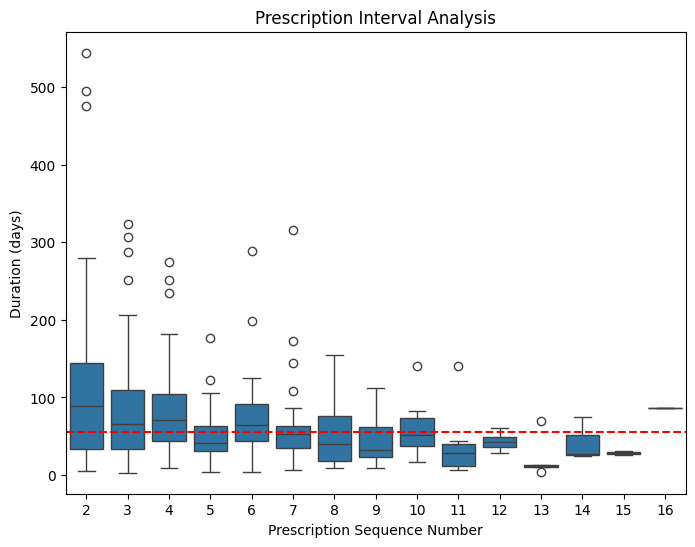

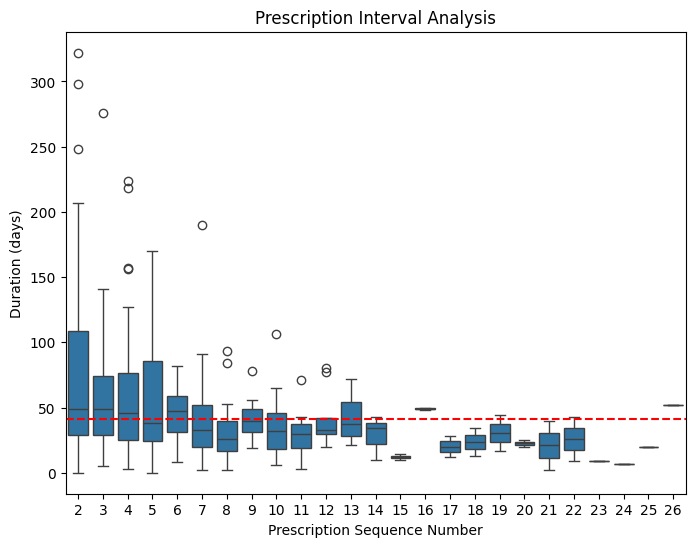

In [13]:
medA = See(df, "medA")
medB = See(df, "medB")

see_assumption(medA)
see_assumption(medB)

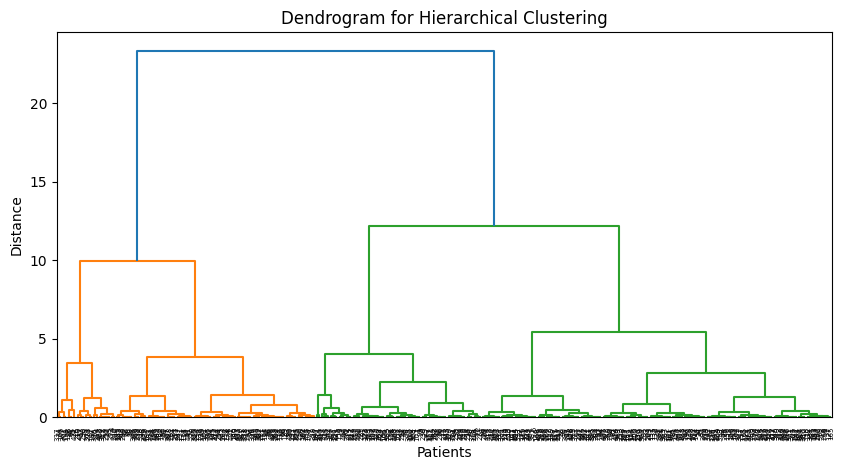

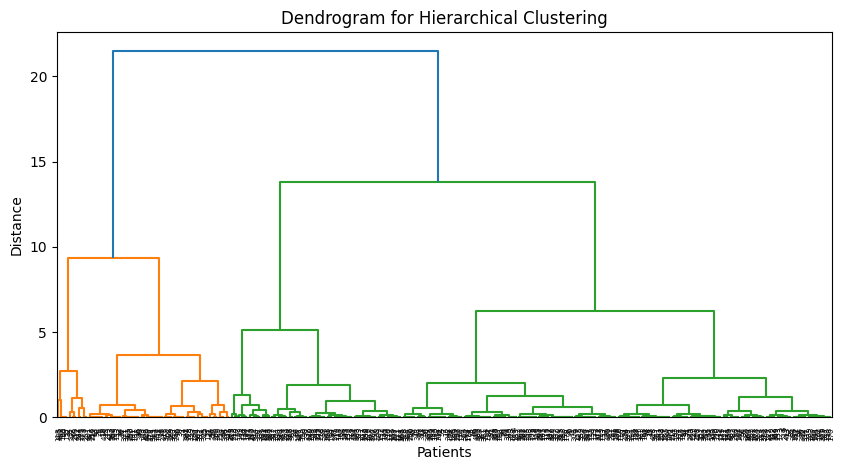

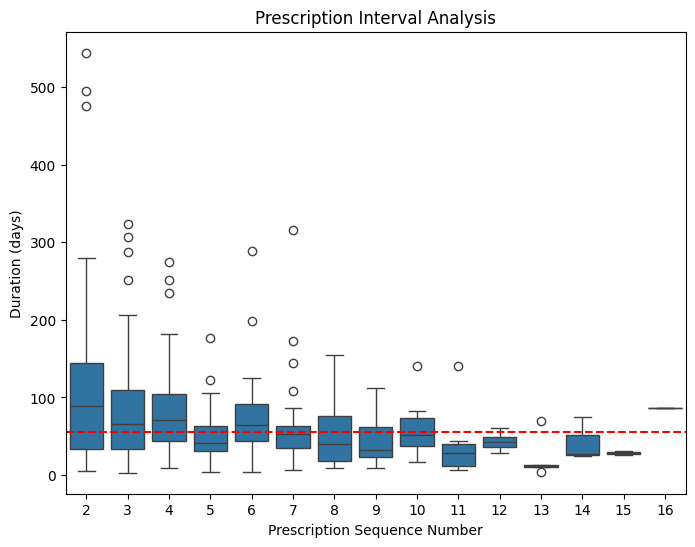

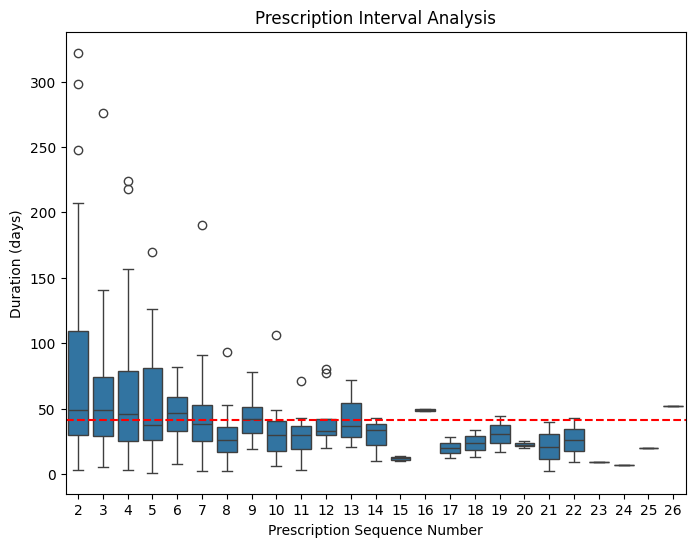

In [14]:
medA_hierarchical, ranges_hierarchical = See_hierarchical(df, "medA")
medB_hierarchical, ranges_hierarchical = See_hierarchical(df, "medB")

see_assumption(medA_hierarchical)
see_assumption(medB_hierarchical)

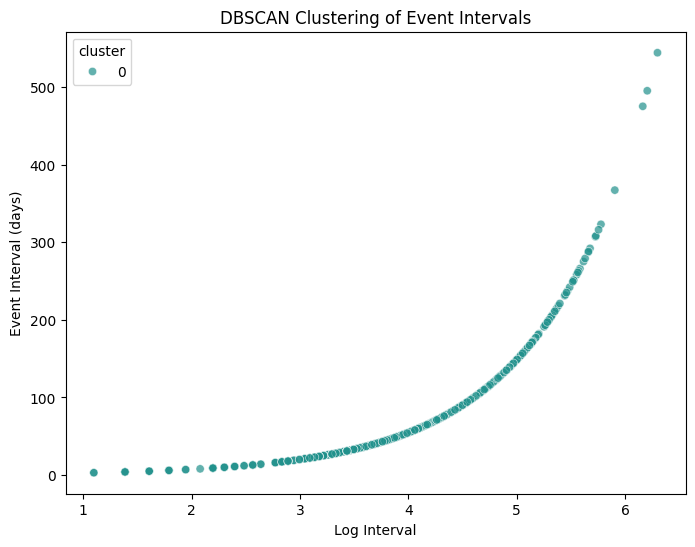

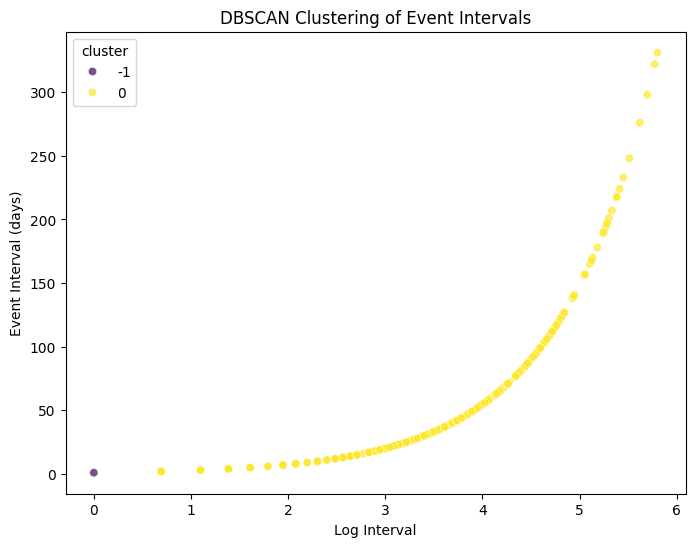

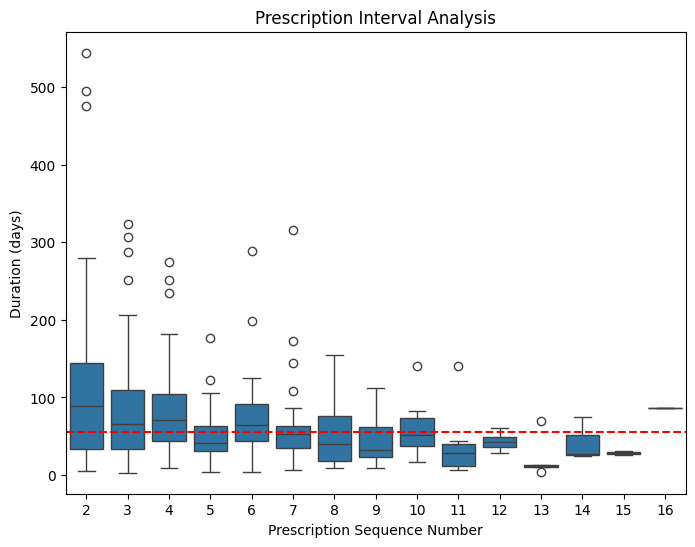

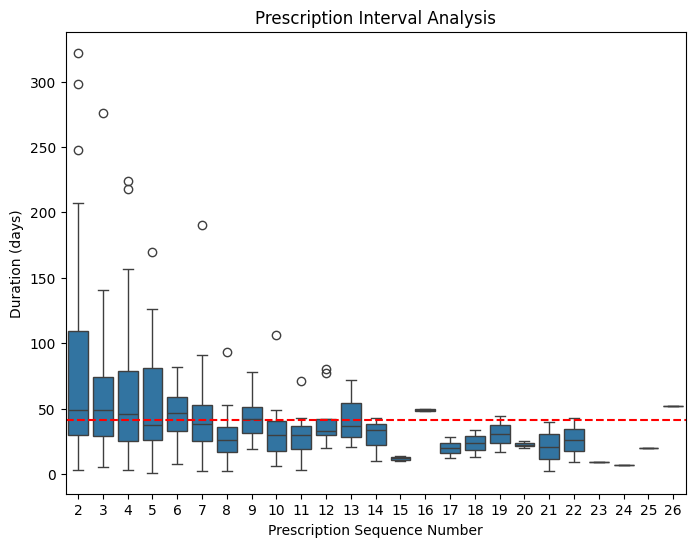

In [15]:
medA_dbscan, ranges_dbscan = See_dbscan(df, "medA")
medB_dbscan, ranges_dbscan = See_dbscan(df, "medB")

see_assumption(medA_dbscan)
see_assumption(medB_dbscan)

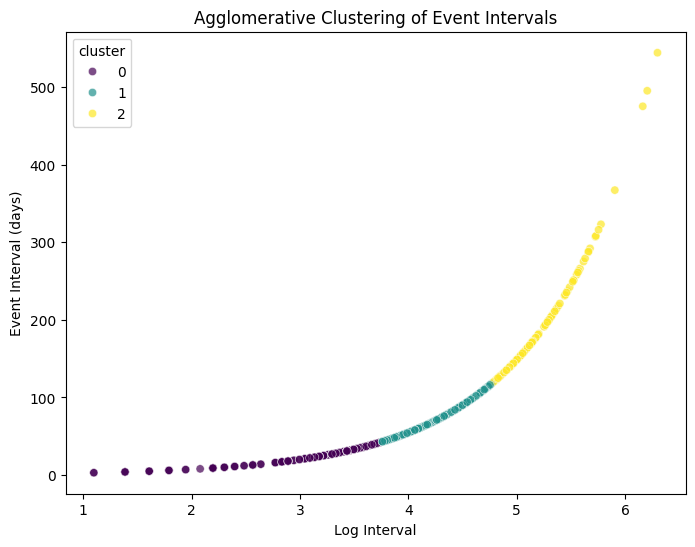

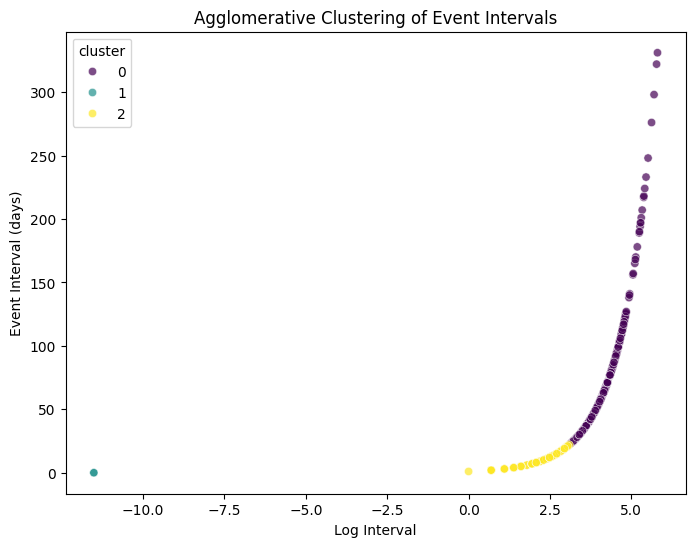

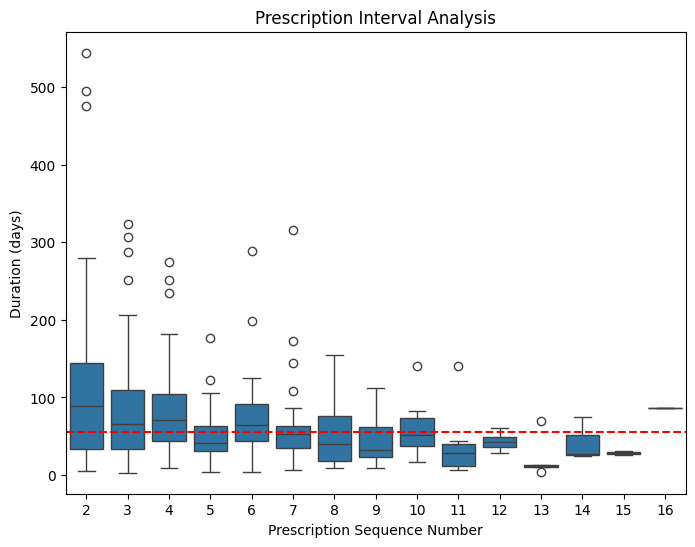

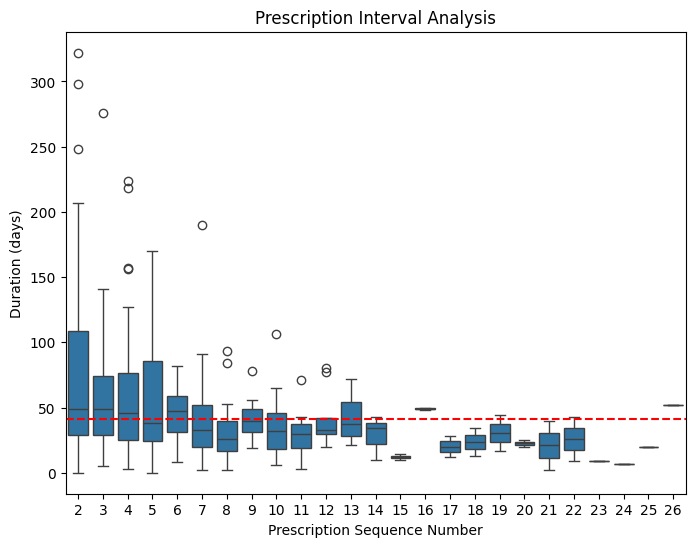

In [16]:
medA_agglomerative, ranges_agglomerative = See_agglomerative(df, "medA")
medB_agglomerative, ranges_agglomerative = See_agglomerative(df, "medB")


see_assumption(medA_agglomerative)
see_assumption(medB_agglomerative)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


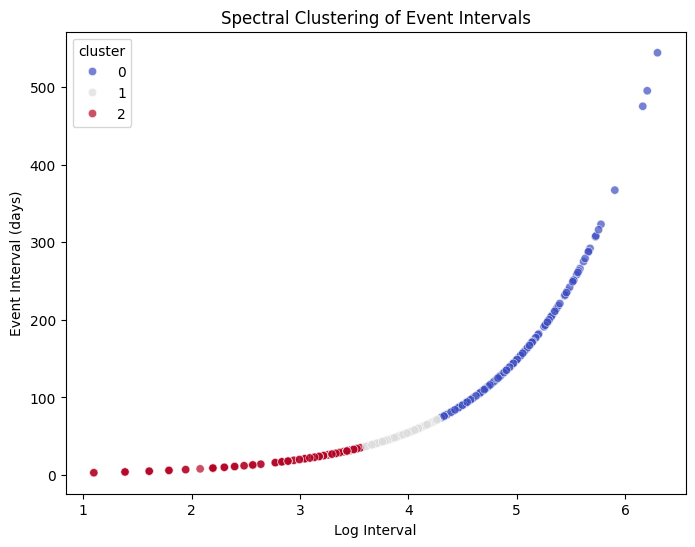

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


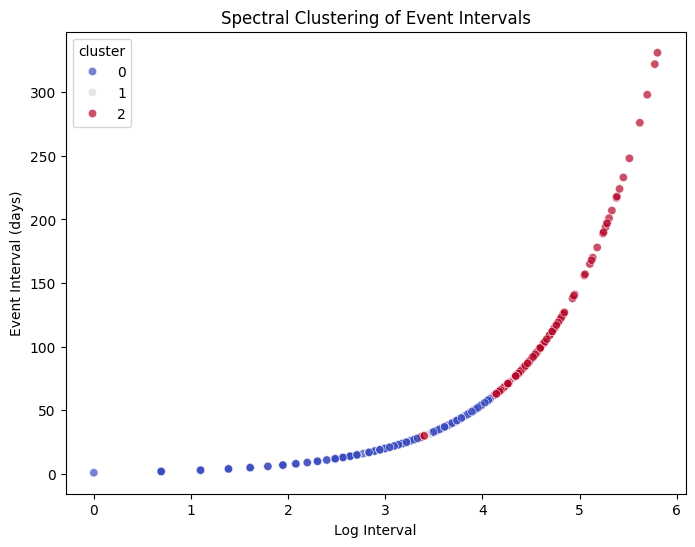

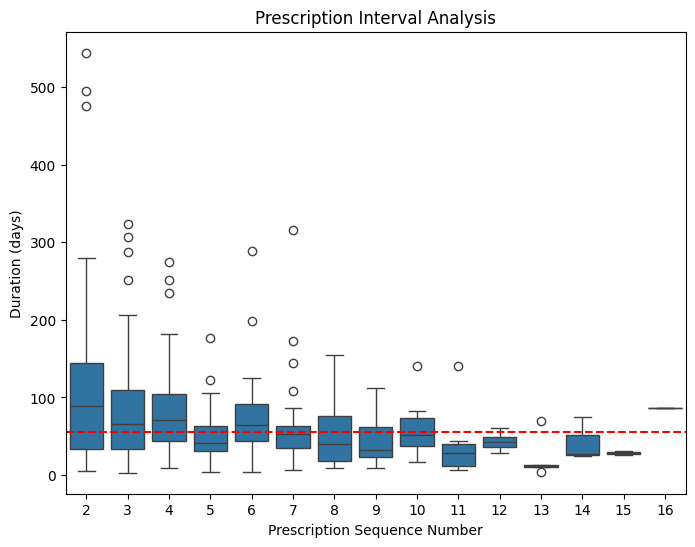

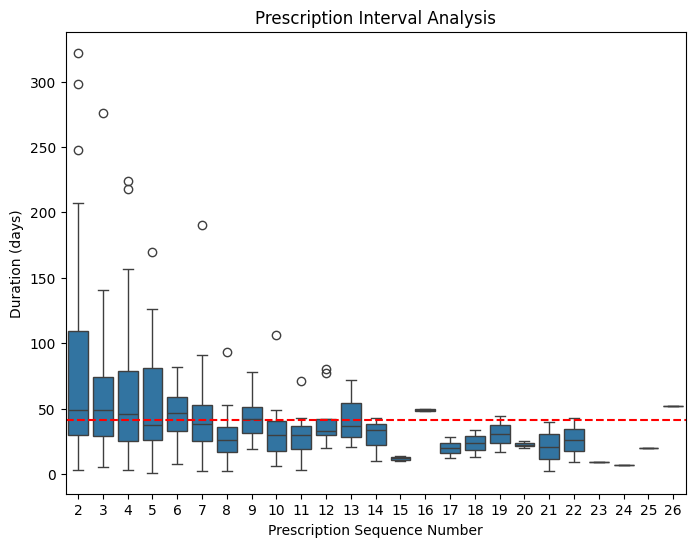

In [17]:
medA_spectral, ranges_spectral = See_spectral(df, "medA")
medB_spectral, ranges_spectral = See_spectral(df, "medB")

see_assumption(medA_spectral)
see_assumption(medB_spectral)

# BOXPLOTS FOR medA AND medB

## GENERAL OBSERVATIONS
- **Decreasing Variability**: As the sequence number increases, both medications show reduced variability in prescription intervals. This pattern suggests that patients gradually adopt more consistent refill habits over time.
- **Initial Irregularity**: Early sequences display a wider range of intervals and outliers, possibly indicating initial challenges in adherence or patient adaptation to new medication routines.
- **Median Duration**: The red dashed line (overall median) tends to stabilize or decline in later sequences, reflecting more regular intervals.

## SPECIFIC INSIGHTS

### medA
- **Higher Initial Variability**: Early sequences can range from 0 to over 500 days, with a large number of outliers. This points to significant differences in how patients adapt to medA at the outset.
- **Stabilization**: After roughly the 5th sequence, prescription intervals tighten around a median of ~50 days, with fewer extreme values.

### medB
- **Lower Overall Duration**: The median duration for medB generally remains around ~50 days and appears slightly lower than medA’s in early sequences.
- **Consistent Pattern**: Variability decreases more noticeably over time compared to medA, creating a tight clustering of intervals by the later sequences.

## POTENTIAL ACTIONS / IMPLICATIONS
- **Early Patient Support**: Provide additional guidance or interventions to patients during the first few prescription cycles to reduce outliers and establish consistent routines.
- **Follow-Up Programs**: Identify patients with highly variable early sequences for targeted follow-up to address potential barriers (e.g., side effects, forgetfulness).
- **Outlier Analysis**: Investigate the causes behind extremely long or short intervals in the early sequences to refine adherence strategies.

---

# 2. HIERARCHICAL CLUSTERING (DENDROGRAMS) FOR medA AND medB

## GENERAL OBSERVATIONS
- **Cluster Formation**: The dendrograms reveal clear divisions into clusters, with merging height indicating the dissimilarity between groups.
- **Number of Clusters**: Large vertical gaps in the dendrogram suggest natural cut points, typically resulting in a few distinct clusters for both medA and medB.
- **Cluster Size**: Wider branches at the base of the dendrogram indicate larger patient groups exhibiting similar refill patterns.

## SPECIFIC INSIGHTS

### medA
- **Distinct Clusters**: The dendrogram points to a few large, clearly separated clusters, suggesting multiple prescription-adherence patterns within the population.
- **Potential Outliers**: Certain branches merge at higher distances, indicating smaller subgroups or individuals with unique behaviors.

### medB
- **Similar Structure**: medB’s dendrogram also shows well-defined clusters, with separation reflective of different refill habits.
- **Balanced Clusters**: Compared to medA, the cluster sizes appear more uniform, suggesting a more evenly distributed set of prescription behaviors.

## POTENTIAL ACTIONS / IMPLICATIONS
- **Cluster Analysis**: Examine the demographic and clinical characteristics of each cluster to understand underlying adherence patterns.
- **Targeted Interventions**: Design specific interventions or reminders for distinct clusters, improving consistency of medication use.
- **Outlier Management**: Identify and investigate individuals who form the higher-distance merges to tailor support strategies.

---

# 3. HIERARCHICAL CLUSTERING (BOXPLOTS) FOR medA AND medB

## GENERAL OBSERVATIONS
- **Variability in Early Sequences**: High prescription-interval dispersion occurs initially for both medications.
- **Stabilization Over Time**: Intervals converge around a predictable median as patients progress through subsequent refills.
- **Outliers Detected**: Large outliers, especially in early sequences, indicate periodic substantial gaps between refills.

## SPECIFIC INSIGHTS

### medA
- **Early Range (0–500+ days)**: Median around 100 days during the first sequences, reflecting significant variability.
- **Stabilization Around 50 Days**: After the 5th sequence, intervals stabilize, with few outliers above 300 days.

### medB
- **Consistency from the Start**: Median hovers around 50 days, with some fluctuations in the first few sequences.
- **Decreasing Variability**: After five sequences, the data clusters tightly around the median, and outliers fall below 200 days.

## POTENTIAL ACTIONS / IMPLICATIONS
- **Early Intervention**: Focus on reducing the gap in the initial sequences, potentially improving long-term adherence patterns.
- **Personalized Approaches**: Tailor interventions or reminders for individuals showing extreme early outliers.
- **Continuous Monitoring**: Keep track of these intervals over time to detect any resurgence in variability.

---

# 4. DBSCAN CLUSTERING (SCATTER PLOTS) FOR medA AND medB

## GENERAL OBSERVATIONS
- **Density-Based Clustering**: DBSCAN forms clusters where data points are dense and labels sparse areas as noise.
- **Log Interval vs. Event Interval**: Plots depict prescription intervals on a logarithmic scale versus actual days.

## SPECIFIC INSIGHTS

### medA
- **Single Cluster**: All data points fall into one cluster (0), indicating a homogeneous distribution of prescription intervals.
- **No Noise Points**: The absence of label -1 suggests minimal outliers under the chosen DBSCAN parameters.

### medB
- **One Main Cluster + Noise**: Most points belong to cluster 0, with at least one point labeled -1, indicating an outlier.
- **Potential Outlier**: That noise point is an extreme case at either a very high or very low log interval compared to the rest.

## POTENTIAL ACTIONS / IMPLICATIONS
- **Parameter Tuning**: Adjust DBSCAN parameters (eps, min_samples) to detect subtle differences in medA or to refine outlier detection in medB.
- **Investigate Outliers**: For medB, investigate why certain points are considered noise—possible unusual patient habits or data errors.
- **Uniform Patterns (medA)**: With only one cluster, consider broader interventions unless parameter changes reveal hidden subgroups.

---

# 5. DBSCAN CLUSTERING (BOXPLOTS) FOR medA AND medB

## GENERAL OBSERVATIONS
- **Variability in Early Sequences**: Both medications display wide ranges at the start.
- **Stabilization with Time**: Prescription intervals regularize in subsequent sequences, shifting toward lower variability.
- **Outliers**: Noteworthy outliers appear in the first few sequences, emphasizing potential adherence challenges.

## SPECIFIC INSIGHTS

### medA
- **Range 0–500 Days**: Early sequences show a median near 100 days, gradually settling around ~50 days after the 5th refill.
- **High Outliers >300 Days**: These persist primarily in the first 3–4 sequences.

### medB
- **Consistent ~50-Day Median**: The central tendency remains near 50 days, even early on.
- **Lower Outlier Threshold (>200 Days)**: Outliers still appear in the first few sequences but become rare afterward.

## POTENTIAL ACTIONS / IMPLICATIONS
- **Early Intervention**: Use the boxplots to identify and intervene with patients who have irregular start patterns.
- **Cluster-Specific Follow-Up**: Although DBSCAN may show mostly one large cluster, the boxplots confirm pockets of outliers needing targeted engagement.
- **Root-Cause Analysis**: Explore whether logistical, educational, or health-related issues drive large gaps in early sequences.

---

# 6. AGGLOMERATIVE CLUSTERING FOR medA AND medB

## GENERAL OBSERVATIONS
- **Bottom-Up Clustering**: Agglomerative methods merge individual points (or small clusters) to form larger clusters.
- **Variability and Outliers**: The raw data (boxplots) show wide early intervals, gradually converging in later sequences.

## SPECIFIC INSIGHTS

### medA
- **Scatter Plot**: Divided into ~3 clusters (0, 1, 2). Cluster 2 captures longer intervals, while clusters 0 and 1 align with shorter intervals.
- **Boxplot**: Early sequences may range 0–500+ days, but the median eventually stabilizes ~50 days.

### medB
- **Scatter Plot**: Also ~3 clusters, with cluster 2 including the longer intervals. A few outliers with unusually short or long intervals appear in clusters 0 or 1.
- **Boxplot**: Durations start around 50 days, with fewer outliers after sequence 5.

## POTENTIAL ACTIONS / IMPLICATIONS
- **Cluster-Specific Approaches**: Tailor interventions based on the typical intervals in each cluster. Patients in the “long-interval” cluster might require different strategies than those in “short-interval” clusters.
- **Focus on Early-Sequencing Behavior**: Because many outliers appear initially, bridging that gap early can significantly reduce future deviations.
- **Longitudinal Monitoring**: Continue to track these clusters over time to see if patient behavior changes and whether re-clustering or new interventions are needed.

---

# 7. SPECTRAL CLUSTERING FOR medA AND medB

## GENERAL OBSERVATIONS
- **Graph-Based Approach**: Spectral clustering transforms the data using similarity graphs, helping to detect complex cluster boundaries.
- **Early Irregularities & Later Consistency**: Like the other methods, early sequences exhibit higher variability, while later sequences converge on a more stable interval.

## SPECIFIC INSIGHTS

### medA
- **Scatter Plot**: Typically ~3 clusters. Cluster 0 includes longer intervals; clusters 1 and 2 feature shorter intervals.
- **Boxplot**: After about five sequences, medA intervals tighten near ~50 days, though some outliers remain above 300 days.

### medB
- **Scatter Plot**: Similar clustering structure, indicating three distinct groups. Cluster 2 tends to represent longer intervals, while cluster 1 may hold some short-interval outliers.
- **Boxplot**: The median hovers at ~50 days, and outliers beyond 200 days gradually disappear in later sequences.

## POTENTIAL ACTIONS / IMPLICATIONS
- **Cluster-Based Care**: Identify the clusters with longer intervals or more outliers to provide targeted support.
- **Reinforce Routine**: Encourage patients with short intervals to avoid unnecessary refills too early, sustaining a balanced prescription cycle.
- **Dynamic Reassessment**: Because spectral clustering can be sensitive to parameter changes (e.g., number of neighbors), periodically re-evaluate the data to detect evolving patterns.
